# Viscoelasticity

FILE: viscoelastic_models.ipynb

AUTHOR: R Ellingham

DATE: Nov 2020

PROGRAM DESC: 
This document looks at the basic theory behind viscoelasticity, with the intention of using this theory to model a carbon-black silicone rubber comoposite. The document will be broken down into sections:

TODO:
* ...
* ...

*Part 1*
* General overview of viscoelasticity
* Maxwell models
* Kelvin-Voight models
* Generalised viscoelastic constitutive models
* Quasi-linear viscoelastic model
* How to fit these models to experimental data

*Part 2*
* Macro vs. micro modelling of viscoelasticity

*Part 3*
* Percolation modelling
* Composite resistivity modelling

In [3]:
## import libraries
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib import cm # colour map
import numpy as np
from scipy import optimize

## General overview

A viscoelastic material displays a loss of energy when ungoing a stress loading and unloading condition. This loss of energy is due to the damping (or viscous) properties of the material as opposed to an ideal elastic material which stores the strain energy as elastic energy. 

<img src=stress-strain-hysteresis-curve.PNG width=400>

This viscoelastiv behavious is desriable for use in systems which require damping and shock absorption, such as in car suspension systems, shipping packing materials and running shoes.

There are two key characteristics of viscoelastic materials, stress relaxation and strain creep.

*Stress relaxation* and *Strain creep* are the time dependent stress and strain responses to a step input of strain and stress on a material, respectively.

<figure>
  <img src="relaxation-sketch.PNG" width=300>
  <figcaption>Stress relaxation curve</figcaption>
  <img src="creep-sketch.PNG" width=300>
  <figcaption>Strain creep curve</figcaption>
</figure>

# Maxwell Model #
<figure>
  <img src="maxwell-sketch.png" width=300>
  <figcaption>Mechanical representation of the Maxwell model of a viscoelastic material with spring constant, $E$ and damping factor $\mu$ in serial configuration</figcaption>
</figure>

\begin{equation*}
\dot{u}(t)=\frac{\dot{F_s}(t)}{E}+\frac{F_d(t)}{\mu} \newline
\therefore q_1\dot{\varepsilon} = p_0\dot{\sigma}+p_1\sigma
\end{equation*}

Where $u(t)$, $F_s$ and $F_d$ are the overall stretch, spring force, and dashpot force respectively. $q_1, p_0, and p_1$ are all constants relating to the elasticity and damping parameters of the material.

\begin{equation*}
q_1 = 1 \rightarrow Dim = 1 \newline
p_1 = \frac{1}{\mu} \rightarrow Dim = \frac{[m]}{[N][s]} \newline
p_0 = \frac{1}{E} \rightarrow Dim = \frac{[m]}{[N]}
\end{equation*}


## Stress relaxation ##

For a constant strain step input the general dynamic Maxwell equation becomes:

\begin{equation*}
0 = \dot{\sigma} + \frac{p_1}{p_0}\sigma
\end{equation*}

The solution for this $1^{st}$ order ODE is:

\begin{equation*}
\sigma = C_1e^{-\frac{p_1}{p_0}t}
\end{equation*}

To solve for $C_1$ we integrate equation (1) from $t=0^-$ to $t=0^+$ and obtain:

\begin{equation*}
\sigma(t=0) = \sigma_0 = C_1 = \frac{q_1}{p_0}\varepsilon_0 = E\varepsilon_0 \newline
\therefore \sigma(t) = E\varepsilon_0e^{-\frac{E}{\mu}t} \newline
\end{equation*}

Hence we get the relaxation function, $G(t)$ in,
\begin{equation*}
\sigma(t) = G(t)\varepsilon_0
\end{equation*}

Text(0, 0.5, 'b=Stress, o=Strain')

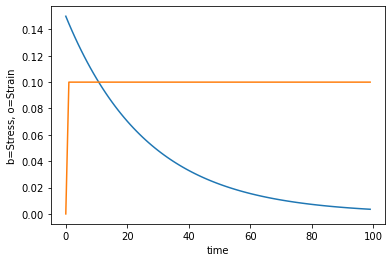

In [4]:
# Step function for general use (only approximate,no 0- and 0+)
step_input = lambda x,steps : np.append(np.zeros(1),np.linspace(x,x,steps-1))
# Stress relaxation function for Maxwell model
maxwell_stress_lax = lambda e0,E,mu,t : E*e0*np.exp(-(E/mu)*t)
# Abitrary parameter values
e0 = 0.1
E = 1.5
mu = 4
steps = 100
t = np.linspace(0,10,steps)
plt.plot(maxwell_stress_lax(e0,E,mu,t))
plt.plot(step_input(e0,steps))
plt.xlabel('time')
plt.ylabel('b=Stress, o=Strain')

## Strain creep ##

For a constant stress step input the general dynamic Maxwell equation becomes:

\begin{equation*}
q_1\dot{\varepsilon} = p_1\sigma
\end{equation*}

We integrate over $0^-$ to $t$ to get:

\begin{equation*}
\varepsilon(t) = \frac{p_1}{q_1}\sigma_0t + C_1
\end{equation*}

Given the ICs previously found for the Stress relaxation:
\begin{equation*}
\varepsilon(t=0) = \varepsilon_0 = \frac{p_0}{q_1}\sigma_0 = C_1 \newline
\therefore \varepsilon(t) = \sigma_0(\frac{1}{E}t + \frac{1}{E}) \newline
\end{equation*}

We have the creep function, $J(t)$ in,
\begin{equation*}
\varepsilon(t) = J(t)\sigma_0
\end{equation*}

Text(0, 0.5, 'o=Stress, b=Strain')

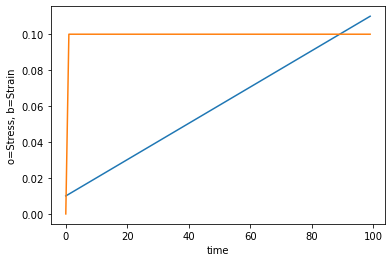

In [5]:
# Creep function
maxwell_strain_creep = lambda s0,E,mu,t : s0*((1/E)*t+1/mu)
# Abitrary parameter values
s0 = 0.1
E = 10
mu = 10
steps = 100
t = np.linspace(0,10,steps)
plt.plot(maxwell_strain_creep(s0,E,mu,t))
plt.plot(step_input(s0,steps))
plt.xlabel('time')
plt.ylabel('o=Stress, b=Strain')

The above plot shows that this model is not realistic for many materials, but good for materials near their melting point or in a gel or viscous liquid state.

# Kelvin-Voight Model #
<figure>
  <img src="kelvin-voight-sketch.png" width=300>
  <figcaption>Mechanical representation of the Kelvin-Voight model of a viscoelastic material with spring constant, $E$ and damping factor $\mu$ in parallel configuration </figcaption>
</figure>

The governing dynamic equation for the Kelvin-Voight model:
\begin{equation*}
F(t) = Eu(t) + \mu \dot{u}(t) \newline
\therefore \sigma(t) = E\varepsilon(t) + \mu\dot{\varepsilon}(t)
\end{equation*}

## Stress relaxation ##

For a constant strain step input the general dynamic Kelvin-Voight equation is integrated from $0^-$ to $0^+$ becomes:

\begin{equation*}
\sigma(t) = E\varepsilon_0 + \mu\varepsilon_0\delta(t) \newline
= \varepsilon_0(E + \mu\delta(t))
\end{equation*}

The dirac delta function is formed since the stress must have a finite area under its curve from $0^-$ to $0^+$ for the integral of $\sigma(t)$

Hence we get the relaxation function, $G(t)$ in,
\begin{equation*}
\sigma(t) = G(t)\varepsilon_0
\end{equation*}

Text(0, 0.5, 'b=Stress, o=Strain')

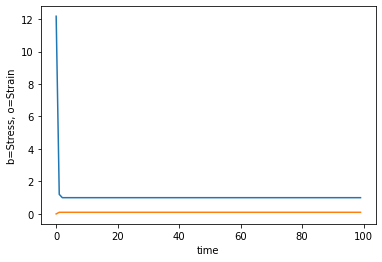

In [6]:
# Dirac delta function
# dt = 2a -> where a is determines the width of the dirac delta function
dirac = lambda t,dt : 2/(dt*np.sqrt(np.pi))*np.exp(-(2*t/dt)**2)
# Relaxation function
kv_stress_lax = lambda e0,E,mu,t : e0*(E + mu*dirac(t,t[1]))
# Abitrary parameter values
e0 = 0.1
E = 10
mu = 10
steps = 100
t = np.linspace(0,10,steps)

plt.plot(kv_stress_lax(e0,E,mu,t))
plt.plot(step_input(e0,steps))
plt.xlabel('time')
plt.ylabel('b=Stress, o=Strain')

This gives an instantaneous stress relaxation for the step function transition as seen in the above plot.

## Strain creep ## 
For a constant stress step input the general dynamic Kelvin-Voight equation we get:

\begin{equation*}
\frac{\sigma_0}{\mu} = \frac{E}{\mu}\varepsilon(t) + \dot{\varepsilon}(t)
\end{equation*}

We solve this ODE to get:
\begin{equation*}
\varepsilon(t) = \frac{\sigma_0}{E} + C_1e^{-\frac{E}{\mu}t}
\end{equation*}

Solving for $C_1$ about $t=0$:
\begin{equation*}
\varepsilon(t=0) \rightarrow C_1 = -\frac{\sigma_0}{E} \newline
\therefore \varepsilon(t) = \frac{\sigma_0}{E}(1 - e^{-\frac{E}{\mu}t})
\end{equation*}

Hence we get a creep function $J(t)$,
\begin{equation*}
\varepsilon(t) = J(t)\sigma_0
\end{equation*}

Text(0, 0.5, 'o=Stress, b=Strain')

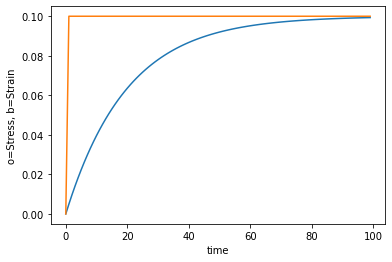

In [7]:
# Creep function
kv_strain_creep = lambda s0,E,mu,t : (s0/E)*(1-np.exp(-(E/mu)*t))
# Abitrary parameter values
s0 = 0.1
E = 1
mu = 2
steps = 100
t = np.linspace(0,10,steps)
plt.plot(kv_strain_creep(s0,E,mu,t))
plt.plot(step_input(s0,steps))
plt.xlabel('time')
plt.ylabel('o=Stress, b=Strain')

# Other models #
There are many other models which can be used for viscoelastic dynamics, which contain variation of springs and dashpots connected in series and parallel. One key example is the Burger creep and relaxation models:
<figure>
  <img src="burger-creep-sketch.jpg" width=300>
  <img src="burger-relax-sketch.jpg" width=300>
  <figcaption>Mechanical representation of the Burger model of a viscoelastic material with spring constants, $E$ and damping factors $\mu$. Top: Burger creep representation. Bottom: Burger relaxation representation.
    </figcaption>
</figure>

# Generalised viscoelastic constitutive model and the Boltzmann superposition principle #
 We now know that viscolelastic materials have an effective strain creep and stress relaxation in response to a stress and strain input respectively. Under the hypothesis that the complete strain or stress history up to time t is related to the state at time $\tau$ is shown in the following equations:

\begin{equation*}
\varepsilon(t) = \int_{0^-}^tJ(t-\tau)d\sigma(\tau)=\sigma(0^+)J(t)+\int_0^tJ(t-\tau)\frac{d}{d\tau}\sigma(\tau)d\tau \newline
\sigma(t) = \int_{0^-}^tG(t-\tau)d\varepsilon(\tau)=\varepsilon(0^+)G(t)+\int_0^tG(t-\tau)\frac{d}{d\tau}\varepsilon(\tau)d\tau
\end{equation*}



The repsonse of a material to a given load is independent of the response of the material to any load which is already applied on the material, and is shown with the plot below:
<figure>
  <img src="boltzmann-superposition-sketch.png" width=400>
  <figcaption> Boltzmann superposition principle
    </figcaption>
</figure>

Text(0, 0.5, 'r=Stress, b=Strain')

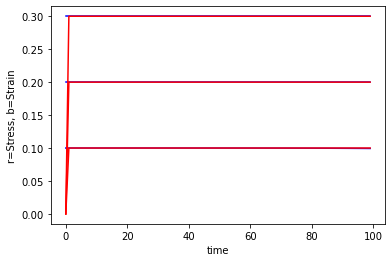

In [10]:
# Creep function
kv_strain_super_creep = lambda s0,E,mu,tau,t : (s0/E)*(1-np.exp(-(E/mu)*(tau-t))) # change this to match above equation
# Abitrary parameter values
s0 = [0.1,0.2,0.3]
tau = [20,40,60]
E = 1
mu = 2
steps = 100
t = np.linspace(0,10,steps)
for i in range(len(s0)):
    plt.plot(kv_strain_super_creep(s0[i],E,mu,tau[i],t),'b-')
    plt.plot(step_input(s0[i],steps),'r-')
plt.xlabel('time')
plt.ylabel('r=Stress, b=Strain')